## Time Series Analysis

Author: Venkata Sritha Gogineni

### Introduction:

#### Time series model:
A time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data. Examples of time series are heights of ocean tides, counts of sunspots, and the daily closing value of the Dow Jones Industrial Average.

TS is a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. But what makes a TS different from say a regular regression problem? There are 2 things:

* It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
* Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.


#### Importing the required libraries in python for analysis

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

### Data upload into a dataframe

In [2]:
covid_df = pd.read_csv('us-counties.csv')

In [3]:
covid_df.head()

,date,county,state,fips,cases,deaths,daily_cases,daily_deaths
0,3/24/20,Autauga,Alabama,1001.0,1,0,1,0
1,3/25/20,Autauga,Alabama,1001.0,4,0,3,3
2,3/26/20,Autauga,Alabama,1001.0,6,0,2,2
3,3/27/20,Autauga,Alabama,1001.0,6,0,0,0
4,3/28/20,Autauga,Alabama,1001.0,6,0,0,0


### Casting the date data types

In [4]:
covid_df['date'] = covid_df['date'].astype('datetime64[ns]')
covid_df = covid_df.sort_values(by = 'date')

## Plotting the timeseries model

### Over here I am grouping the rides data set by date

In [5]:
#covid_date_df = covid_df.groupby(["date"]).count().reset_index(name="count")
us_agg_df = covid_df.groupby(["date"], as_index = False)[["cases", "deaths","daily_cases","daily_deaths"]].sum()

us_agg_df['date'] = us_agg_df['date'].astype('datetime64[ns]')
us_agg_df = us_agg_df.sort_values(by = 'date')

us_agg_df.head(3)

,date,cases,deaths,daily_cases,daily_deaths
0,2020-01-21,1,0,1,1
1,2020-01-22,1,0,0,0
2,2020-01-23,1,0,0,0


#### Converting the date to be index 

In [6]:
df = us_agg_df.copy()
df.index = pd.to_datetime(df['date'])
df.sort_index(inplace = True)
df.drop(labels=['date'], axis=1, inplace = True)
df.head()

df1 = df.copy()

df = df.drop(["cases", "deaths","daily_deaths"], axis =1)
df.fillna(0)

,daily_cases
date,
2020-01-21,1
2020-01-22,0
2020-01-23,0
2020-01-24,1
2020-01-25,1
...,...
2020-08-03,47528
2020-08-04,53295
2020-08-05,53726


### Plot the time series

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


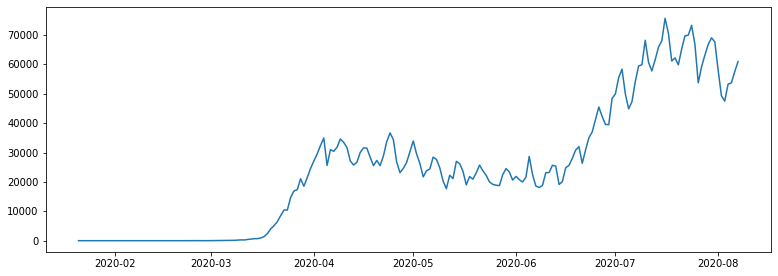

In [7]:
plt.figure(figsize=(13,4.5))

plt.plot(us_agg_df['date'],us_agg_df['daily_cases'])
plt.show()

## Split train/test


In [8]:
ts14_train = df['2020-03':'2020-07'].copy(deep = True)
ts14_test = df['2020-08'].copy(deep = True)

### Plotting the weekly and monthly trends

The monthly trends indicate the cyclic trends in the data

Text(0, 0.5, 'Number of daily cases')

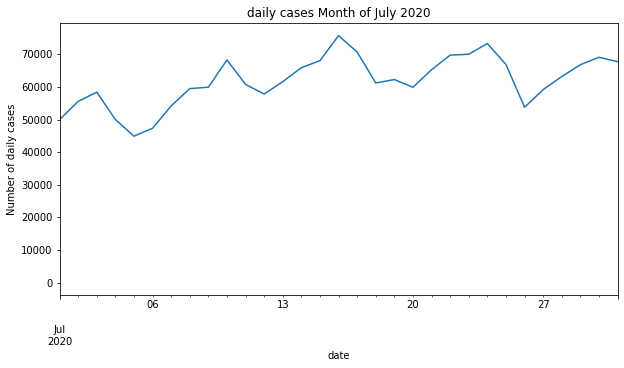

In [9]:
ts14_train[:'2020-07'].plot(figsize=(10,5), 
     title='daily cases Month of July 2020', 
     legend=False, 
     xlim=('2020-07-01', '2020-07-31'))
plt.ylabel('Number of daily cases')

Weekly trends indicate the seasonality trend

Text(0, 0.5, 'Number of daily cases')

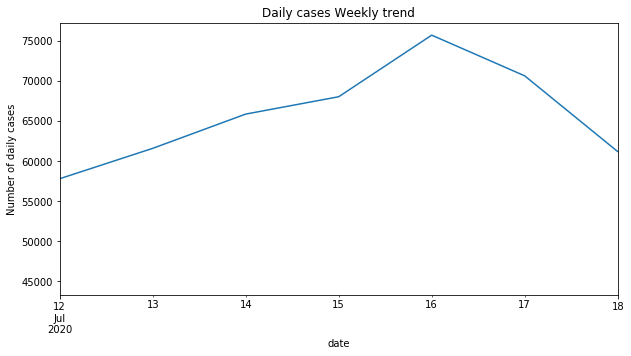

In [10]:
ts14_train['2020-07'].plot(figsize=(10,5), 
     title='Daily cases Weekly trend', 
     legend=False, 
     xlim=('2020-07-12', '2020-07-18'))
plt.ylabel('Number of daily cases')

## Stationarization

A Time Series is stationary, if parameters mean, variance remain constant over time. The TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

* constant mean
* constant variance
* an autocovariance that does not depend on time.

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling=0):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = rolling).mean()
    rolstd = timeseries.rolling(window = rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,5))
    orig = plt.plot(timeseries, color='darkgray',label='Original')
    mean = plt.plot(rolmean, color='darkblue', label='Rolling Mean', lw=1)
    std = plt.plot(rolstd, color='red', label = 'Rolling Std', lw=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Differenced # of Uber Pickups\nx(t) - x(t-1)')
    plt.xlim(timeseries.index.min(), timeseries.index.max())
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    data1 = timeseries.iloc[:,0].values
    dftest = adfuller(data1)
    #print('> ADF Statistic: {:.3f}'.format(result[0]))
    #print('> p-value: {:.3e}'.format(result[1]))
    #print('> Critical Values:')
    #for key, value in result[4].items():
       # print('\t%s: %.3f' % (key, value))
             
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)       

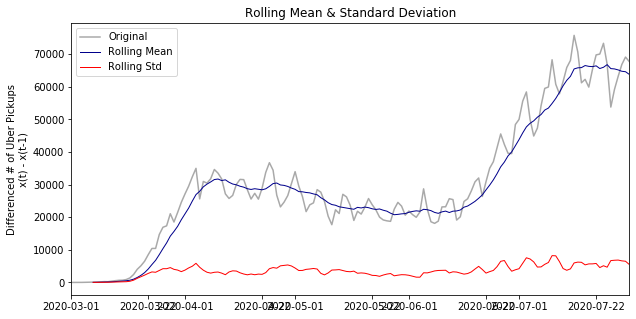

Results of Dickey-Fuller Test:
Test Statistic                  -2.294316
p-value                          0.173808
#Lags Used                       9.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


In [12]:
test_stationarity(ts14_train, rolling=7)

## Explain the Dikey fuller test

Steps to make TS a non-stationary.
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

## Removing trend effect by applying logarthimic

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


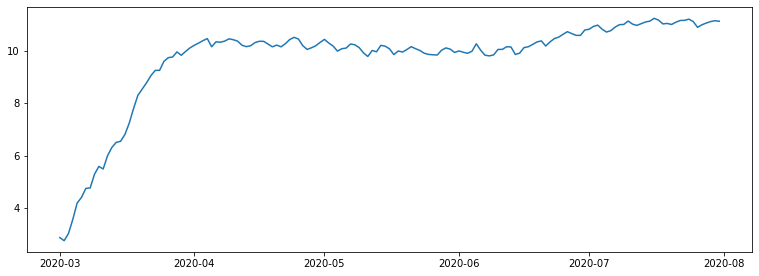

In [13]:
ts14_train_df_log = np.log(ts14_train)
ts14_df_log = np.log(df)

plt.figure(figsize=(13,4.5))
plt.plot(ts14_train_df_log)

### Removing seasonality by using moving average

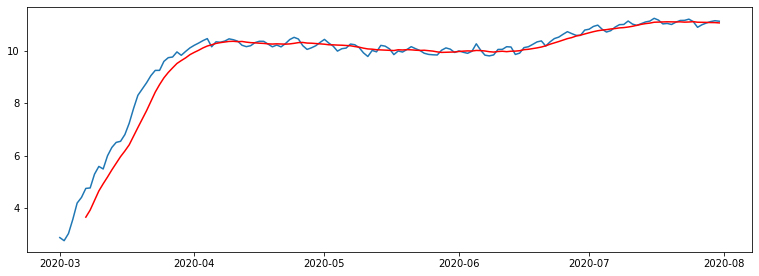

In [14]:
ts14_train_log_movavg_df = ts14_train_df_log.rolling(7).mean()

plt.figure(figsize=(13,4.5))
plt.plot(ts14_train_df_log)
plt.plot(ts14_train_log_movavg_df, color='red')

### Difference the logarthimic and moving average log

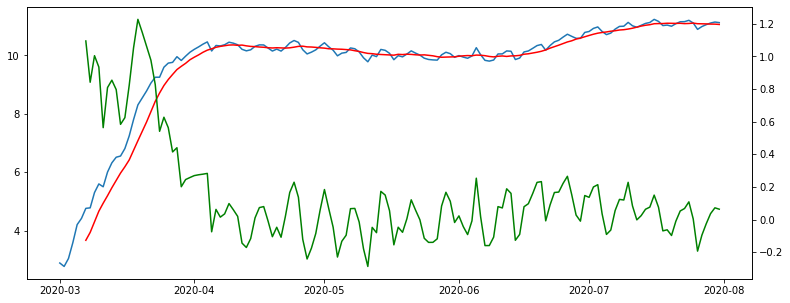

In [15]:
ts_log_moving_avg_diff = ts14_train_df_log - ts14_train_log_movavg_df

ts_log_moving_avg_diff.dropna(inplace=True)

fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(111)

#fig, ax1 = plt.subplots()

ax1.plot(ts14_train_df_log)
ax1.plot(ts14_train_log_movavg_df, color='red')

ax2 = ax1.twinx()

ax2.plot(ts_log_moving_avg_diff, color = 'green')

## Applying the duckfueller on differenced data

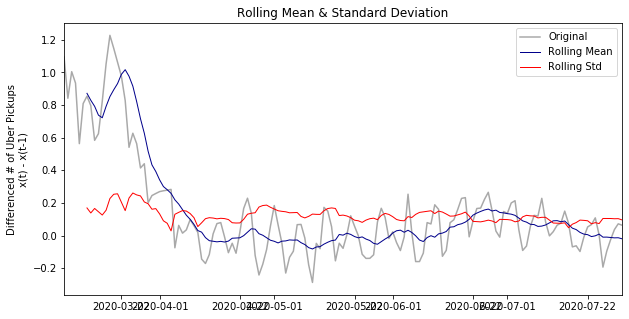

Results of Dickey-Fuller Test:
Test Statistic                  -5.177563
p-value                          0.000010
#Lags Used                      14.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


In [16]:
test_stationarity(ts_log_moving_avg_diff, rolling=7)

## Differencing by 7 days and 28 days seasonal cycle

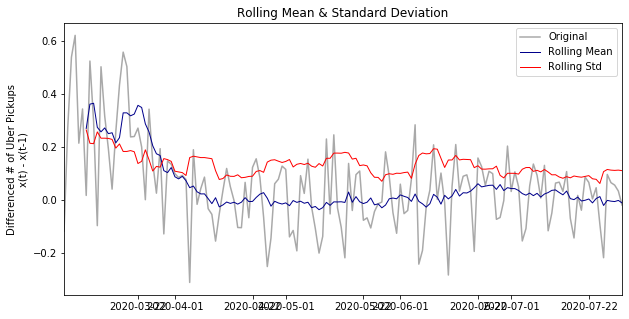

Results of Dickey-Fuller Test:
Test Statistic                  -2.381025
p-value                          0.147164
#Lags Used                      13.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


In [58]:
ts14_train_log = np.log(ts14_train)
ts14_test_log = np.log(ts14_test)

diff14 = ts14_train_log - ts14_train_log.shift()
diff14.dropna(inplace=True)

test_stationarity(diff14, 7)

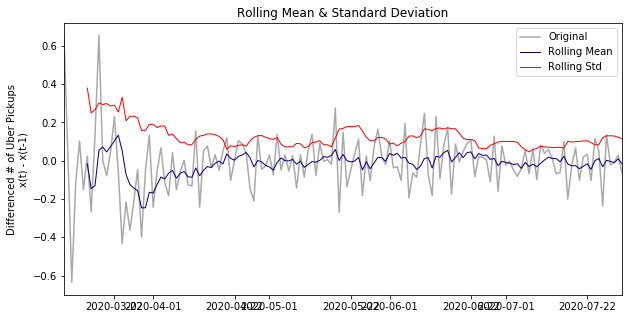

Results of Dickey-Fuller Test:
Test Statistic                  -2.488194
p-value                          0.118373
#Lags Used                      14.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
diff14_2 = diff14-diff14.shift(7)
diff14_2.dropna(inplace=True)

test_stationarity(diff14_2,7)

## Decomposition

It helps us understand the different components of the time series.
* trend
* seasonality
* residual

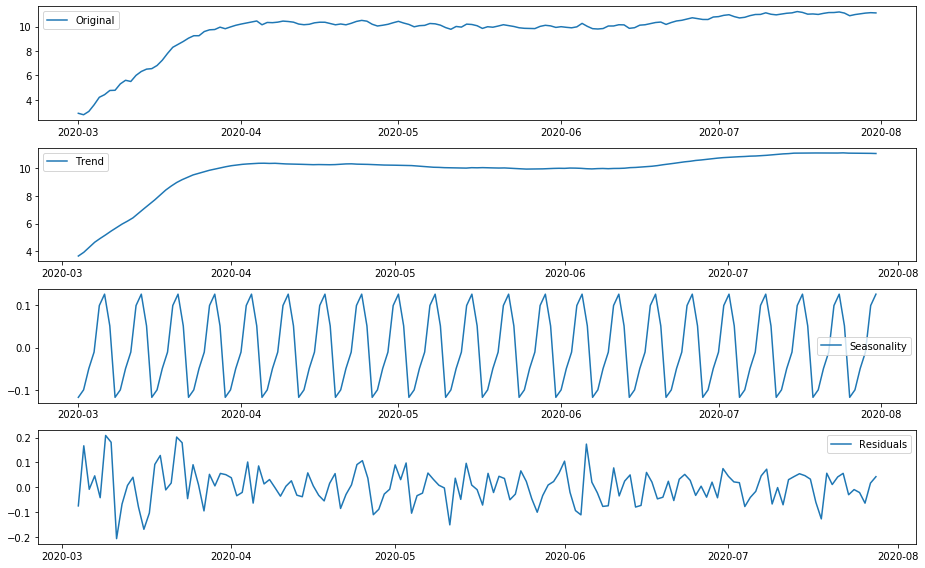

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts14_train_df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(13,8))

plt.subplot(411)
plt.plot(ts14_train_df_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

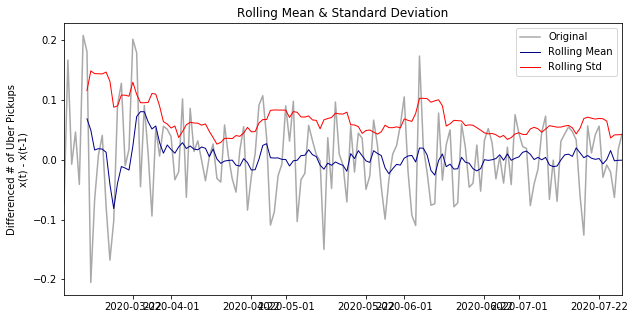

Results of Dickey-Fuller Test:
Test Statistic                -9.214929e+00
p-value                        1.844794e-15
#Lags Used                     2.000000e+00
Number of Observations Used    1.440000e+02
Critical Value (1%)           -3.476598e+00
Critical Value (5%)           -2.881829e+00
Critical Value (10%)          -2.577589e+00
dtype: float64


In [20]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose,7)

## Auto-Correlation Plots

In [21]:
from statsmodels.tsa.stattools import acf, pacf

Text(0.5, 1.0, 'Partial autocorrelation plot')

<Figure size 936x576 with 0 Axes>

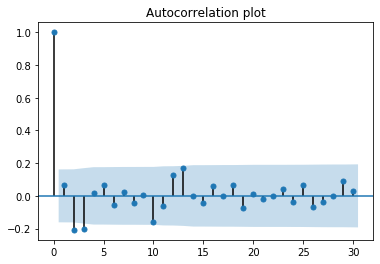

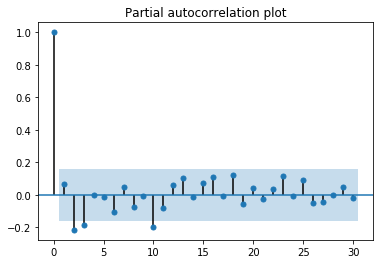

In [22]:
plt.figure(figsize=(13,8))
plot_acf(ts_log_decompose, lags = 30)
plt.title('Autocorrelation plot')
plot_pacf(ts_log_decompose, lags = 30)
plt.title('Partial autocorrelation plot')

### Based on the above Auto-correlation plots we have detemined the values of p,q,d as below

##### p = 1
##### d = 0
##### q = 1

## Arima Model

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
model_1 = ARIMA(ts14_train_log, (1,0,1))
res_101 = model_1.fit(disp=-1)
print(res_101.summary())

                              ARMA Model Results                              
Dep. Variable:            daily_cases   No. Observations:                  153
Model:                     ARMA(1, 1)   Log Likelihood                  58.897
Method:                       css-mle   S.D. of innovations              0.161
Date:                Sat, 15 Aug 2020   AIC                           -109.794
Time:                        12:18:05   BIC                            -97.672
Sample:                    03-01-2020   HQIC                          -104.870
                         - 07-31-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.3199      3.701      1.978      0.050       0.065      14.574
ar.L1.daily_cases     0.9984      0.002    474.231      0.000       0.994       1.003
ma.L1.daily_cases     0.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


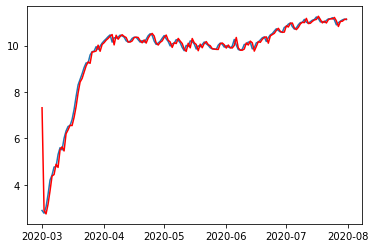

In [25]:
plt.plot(ts14_train_log)
plt.plot(res_101.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((res_101.fittedvalues-diff14)**2))

In [26]:
predictions_ARIMA_diff = pd.Series(res_101.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2020-03-01    7.319864
2020-03-02    2.894638
2020-03-03    2.741193
2020-03-04    3.157608
2020-03-05    3.740594
dtype: float64


In [27]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff#.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2020-03-01    7.319864
2020-03-02    2.894638
2020-03-03    2.741193
2020-03-04    3.157608
2020-03-05    3.740594
dtype: float64


In [59]:
predictions_ARIMA_log = pd.Series(ts14_train_log.ix[0], index=ts14_train_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


date
2020-03-01    7.319864
2020-03-02    2.894638
2020-03-03    2.741193
2020-03-04    3.157608
2020-03-05    3.740594
dtype: float64

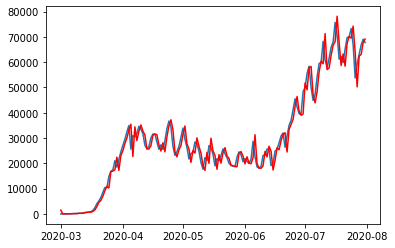

In [60]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts14_train)
plt.plot(predictions_ARIMA, color = 'red')
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [36]:
def arima(data, train_data, p, d, q):
    model = ARIMA(train_data, (p,d,q))
    res = model.fit(disp=-1)
    print(res.summary())

    plt.plot(train_data)
    plt.plot(res.fittedvalues, color='red')
    #plt.title('RSS: %.4f'% sum((res_101.fittedvalues-diff14)**2))
    plt.show()

                              ARMA Model Results                              
Dep. Variable:            daily_cases   No. Observations:                  153
Model:                     ARMA(1, 1)   Log Likelihood                  58.897
Method:                       css-mle   S.D. of innovations              0.161
Date:                Sat, 15 Aug 2020   AIC                           -109.794
Time:                        12:20:09   BIC                            -97.672
Sample:                    03-01-2020   HQIC                          -104.870
                         - 07-31-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.3199      3.701      1.978      0.050       0.065      14.574
ar.L1.daily_cases     0.9984      0.002    474.231      0.000       0.994       1.003
ma.L1.daily_cases     0.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


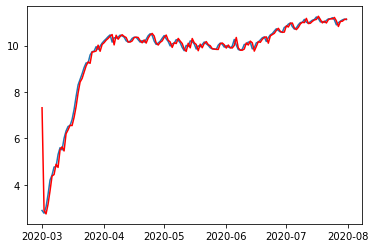

In [37]:
arima(ts14_df_log,ts14_train_log, 1,0,1)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            daily_cases   No. Observations:                  153
Model:                     ARMA(1, 2)   Log Likelihood                  62.266
Method:                       css-mle   S.D. of innovations              0.158
Date:                Sat, 15 Aug 2020   AIC                           -114.532
Time:                        12:20:13   BIC                            -99.380
Sample:                    03-01-2020   HQIC                          -108.377
                         - 07-31-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.4223      3.569      2.079      0.039       0.426      14.418
ar.L1.daily_cases     0.9979      0.003    356.977      0.000       0.992       1.003
ma.L1.daily_cases     0.

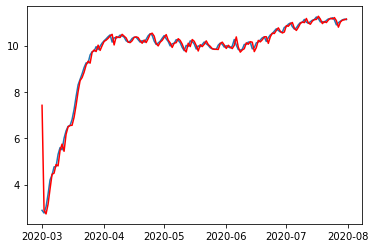

In [39]:
arima(ts14_df_log,ts14_train_log, 1,0,2)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            daily_cases   No. Observations:                  153
Model:                     ARMA(2, 1)   Log Likelihood                  73.478
Method:                       css-mle   S.D. of innovations              0.146
Date:                Sat, 15 Aug 2020   AIC                           -136.956
Time:                        12:20:15   BIC                           -121.804
Sample:                    03-01-2020   HQIC                          -130.801
                         - 07-31-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.3279      3.051      2.402      0.018       1.348      13.308
ar.L1.daily_cases     1.9880      0.012    172.614      0.000       1.965       2.011
ar.L2.daily_cases    -0.

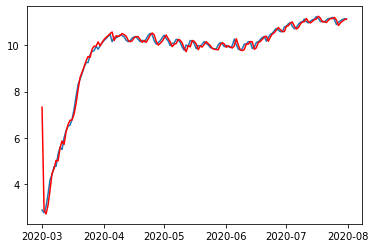

In [40]:
arima(ts14_df_log,ts14_train_log, 2,0,1)

In [42]:
ts14_df_log.head()

,daily_cases
date,
2020-01-21,0.0
2020-01-22,-inf
2020-01-23,-inf
2020-01-24,0.0
2020-01-25,0.0


## Forecasting

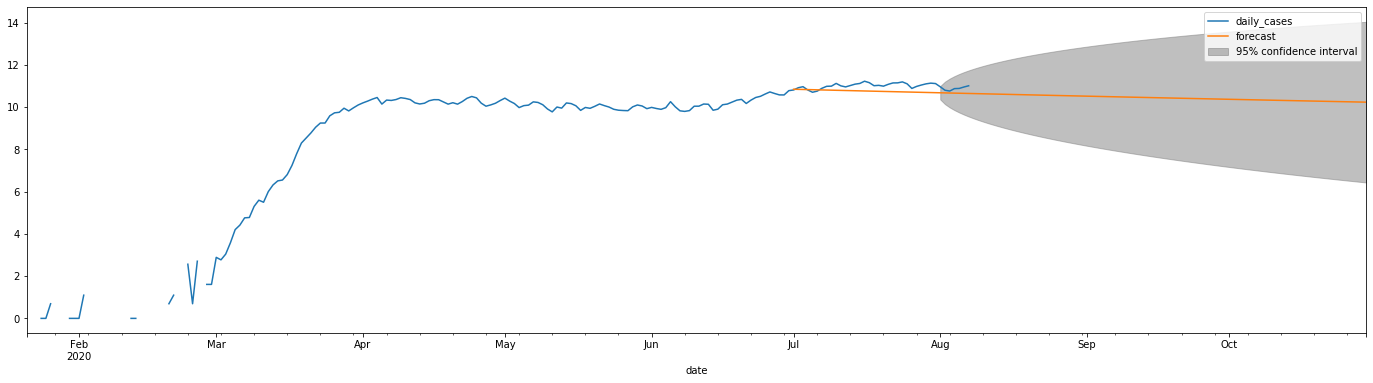

In [53]:
fig, ax = plt.subplots(figsize=(24, 6));
ts14_df_log.index = pd.to_datetime(ts14_df_log.index, format="%Y-%m");
ts14_df_log.dropna().plot(ax=ax);
#ax.vlines('2014-08-01', 5, 6.25, linestyle='--', color='r', label='Start of forecast');
res_101.plot_predict(start = '2020-07-01', end = '2020-10-30', dynamic = True, plot_insample=False, ax=ax);

In [55]:
predictions_ARIMA_diff = pd.Series(res_101.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2020-03-01    7.319864
2020-03-02    2.894638
2020-03-03    2.741193
2020-03-04    3.157608
2020-03-05    3.740594
dtype: float64


In [56]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff#.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2020-03-01    7.319864
2020-03-02    2.894638
2020-03-03    2.741193
2020-03-04    3.157608
2020-03-05    3.740594
dtype: float64


In [61]:
predictions_ARIMA_log = pd.Series(ts14_test_log.ix[0], index=ts14_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


date
2020-03-01    7.319864
2020-03-02    2.894638
2020-03-03    2.741193
2020-03-04    3.157608
2020-03-05    3.740594
dtype: float64

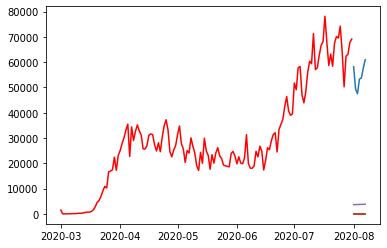

In [62]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA, color = 'red')

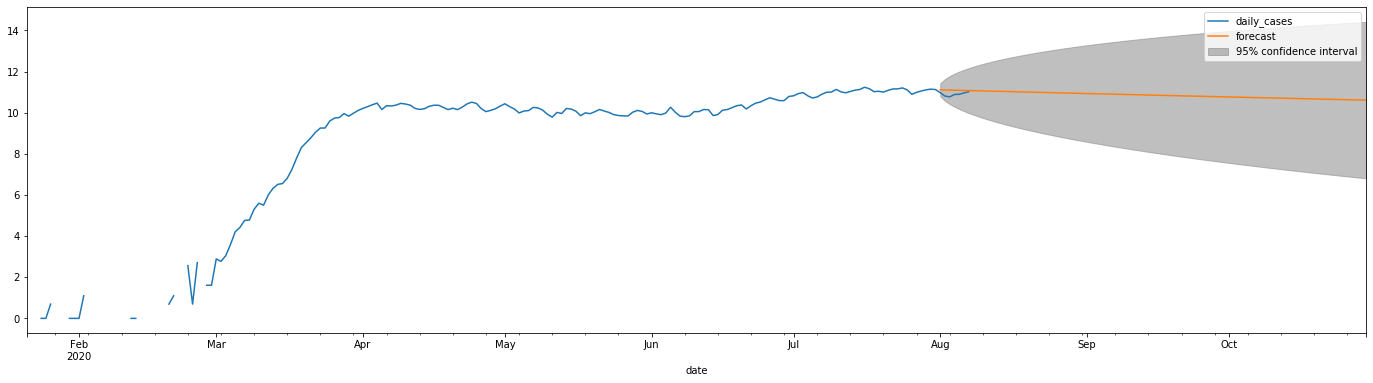

In [47]:
fig, ax = plt.subplots(figsize=(24, 6));
ts14_df_log.index = pd.to_datetime(ts14_df_log.index, format="%Y-%m");
ts14_df_log.dropna().plot(ax=ax);
#ax.vlines('2014-08-01', 5, 6.25, linestyle='--', color='r', label='Start of forecast');
res_101.plot_predict(start = '2020-08-01', end = '2020-10-30', dynamic = True, plot_insample=False, ax=ax);

## SARIMAX

In [149]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax

In [150]:
# create SARIMAX model with previously determined lags
sar_m = sarimax.SARIMAX(ts14_train.values,
                        trend='n', 
                        order=(1,1,1), 
                        seasonal_order=(1,1,1, 7), 
                        #enforce_invertibility=True,
                        simple_differencing=False).fit()

In [151]:
predict_steps = 7*4
forecast = sar_m.forecast(steps=predict_steps)

In [152]:
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Number of daily cases', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(actual.index.date[::7], 
               actual.index.day[::7])
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)

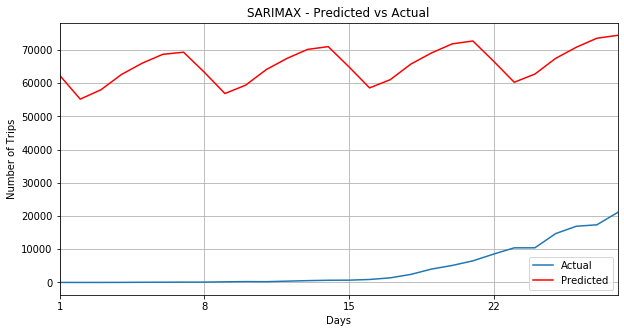

In [153]:
# plot against real data
plot_forecast(ts14_train[:28], forecast, 
              title='SARIMAX - Predicted vs Actual', 
              xlabel='Days', 
              ylabel='Number of Trips')

In [154]:
#Predicting values using the fitted model
def predict(time_series,p,d,q,P,D,Q,s,n_days,conf):
    
    #Splitting into training and testing
    training_ts = time_series[:-n_days]
    
    testing_ts = time_series[len(time_series)-n_days:]
    
    #fitting the model
    SARIMAX_model = SARIMAX(training_ts.astype(float),
                            order=(p,d,q),
                            seasonal_order=(P,D,Q,s),
                            enforce_invertibility=False)
    SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
    
    #Predicting
    SARIMAX_prediction = pd.DataFrame(SARIMAX_model_fit.forecast(steps=n_days,alpha=(1-conf)).values,
                          columns=['Prediction'])
    #SARIMAX_prediction.index = pd.date_range(training_ts.index.max()+1,periods=n_days)
    
    #Plotting
    plt.figure(4)
    plt.title('Plot of original data and predicted values using the ARIMA model')
    plt.xlabel('Time')
    plt.ylabel('Number of cases')
    plt.plot(time_series[1:],'k-', label='Original data')
    plt.plot(SARIMAX_prediction,'b--', label='Next {}days predicted values'.format(n_days))
    plt.legend()
    plt.show()
    
    #Returning predicitons
    return SARIMAX_prediction

#Predicting the values and builing an 80% confidence interval
#prediction = predict(demand_ts14,1,1,1,1,1,1,7,7,0.95)


In [155]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err

### Linear Regression time series forcasting

In [50]:
# create copies of dataframes for linear regression
lr14_train = ts14_train.copy(deep=True)
lr14_test = ts14_test.copy(deep=True)

# helper function for one of the features
def time_since_start(date, start='2020-03-01 00:00:00'):
    date_diff = date - pd.to_datetime(start)
    date_float = date_diff/pd.to_timedelta(1, unit='h')
    return date_float

# add timelagged features
for df in [lr14_train, lr14_test]:
    df['day_of_week'] = df.index.weekday
    df['is_weekend'] = df.index.map(lambda x: 1 if x.weekday() > 4 else 0)
    df['hour_of_day'] = df.index.hour
    df['time_since_jan'] = df.index.map(lambda x: time_since_start(x))

# separate into x and y
X_train = lr14_train[['day_of_week', 'is_weekend', 
                      'hour_of_day', 'time_since_jan']]
X_test = lr14_test[['day_of_week', 'is_weekend',
                    'hour_of_day', 'time_since_jan']]
y_train = lr14_train['daily_cases']
y_test = lr14_test['daily_cases']

In [63]:
from sklearn.linear_model import LinearRegression

# linear regression
lr = LinearRegression().fit(X_train, y_train)
preds = lr.predict(X_test)

# plot forecast
plot_forecast(y_test, preds, 
              title='Linear Regression - Actual vs Forecast', 
              xlabel='Date 2020')

# calculate RMSE error
rmse(y_test, preds)

NameError: name 'plot_forecast' is not defined